# Classifying Reviews by Style

A look into using trying to classify reviews by their style by looking at vectorized terms relative to their counts and frequencies.

A first pass shows that with the dataset as is, there is a lot of noise in the classification due to an imbalanced class. I also suspect that there are also too many classes to perform accurate classification

I am repurposing some of the code from this [this guide](https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f) for my exploration of this dataset. I thought it was very informative in regards to 

I wanted to see how much signal/noise the reviews were giving in terms of connecting style to a review. It possible that this signal exists, but this is not the means of extracting it.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sqlalchemy import create_engine

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score

In [3]:
pg_pass = os.environ['BEER_DB']
engine = create_engine(pg_pass)
pd.read_sql("SELECT tablename FROM pg_catalog.pg_tables WHERE schemaname='public' LIMIT 5", con=engine)

,tablename
0,spatial_ref_sys
1,SequelizeMeta
2,breweries
3,styles
4,reviews


In [4]:
reviews_by_style_count = """
SELECT
styles.name,
COUNT(styles.name)
FROM reviews, styles, beers
WHERE reviews.beer_id = beers.id
AND beers.style_id = styles.id
AND reviews.review_text IS NOT NULL
GROUP BY styles.name
HAVING COUNT(styles.name) > 10000
ORDER BY COUNT DESC;
"""

reviews_count = pd.read_sql(reviews_by_style_count, con=engine)

In [5]:
reviews_count.shape

(34, 2)

In [7]:
reviews_count.head()

,name,count
0,American IPA,216324
1,American Imperial IPA,113925
2,American Pale Ale (APA),81356
3,American Imperial Stout,60405
4,Belgian Saison,52593


In [8]:
reviews_count.tail()

,name,count
29,Bohemian Pilsener,11886
30,Leipzig Gose,11348
31,English Brown Ale,10821
32,German Maibock,10195
33,Irish Red Ale,10018


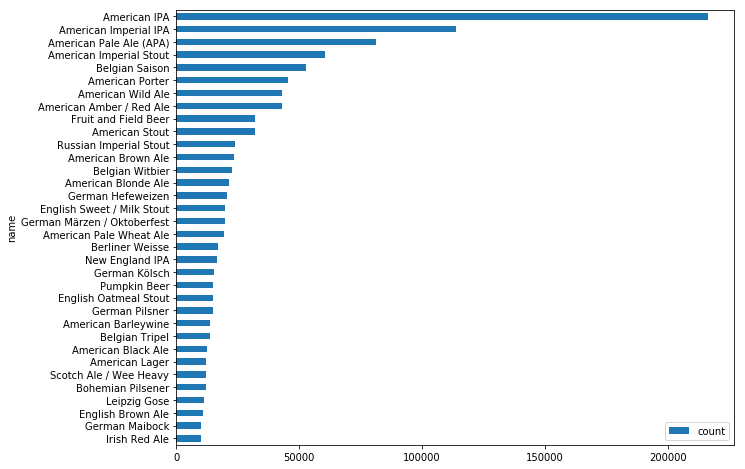

In [9]:
reviews_count.sort_values(by="count", ascending=True).plot(kind="barh", x="name", figsize=(10,8))

In [10]:
reviews_query = """
SELECT 
reviews.review_text,
styles.name as target,
styles.id as target_id
FROM reviews, styles, beers
WHERE reviews.beer_id = beers.id
AND beers.style_id = styles.id
AND reviews.review_text IS NOT NULL
AND reviews.review_text !=''
LIMIT 17000;
"""

reviews = pd.read_sql(reviews_query, con=engine)
reviews.head()

,review_text,target,target_id
0,Had this beer on-tap at the Gordon Biersch in ...,German Märzen / Oktoberfest,16
1,"12 oz. bottle,\nA: Pours amber with a firm whi...",German Märzen / Oktoberfest,16
2,"deep, dark, burgundy hue, bordering on brown, ...",Winter Warmer,72
3,"Appears a hazy, dark amber with a crimson hue ...",American Barleywine,29
4,Appearance - Pours slightly hazy and brilliant...,American Blonde Ale,6


Now we are going to fit the text to a Term Frequency Inverse Document Frequency Vectorizer.

In [11]:
tfidf = TfidfVectorizer(min_df=.05, max_df=0.5, ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(reviews.review_text).toarray()
labels = reviews.target_id
features.shape

(17000, 188)

In [31]:
number_of_terms = 2

styles_to_id = dict(zip(reviews.target, reviews.target_id))

for style, style_id in sorted(styles_to_id.items()):
    features_chi2 = chi2(features, labels == style_id)    
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    # Aggregate results
    # Make word cloud?
    # Or at least subplots
    print(f"{style}:")
    print(f"Most correlated unigrams: { ' '.join(unigrams[-number_of_terms:]) }") 
    print(f"Most correlated bigrams: { ', '.join(bigrams[-number_of_terms:])  }")
    [print() for _ in range(4)]

American Adjunct Lager:
Most correlated unigrams: say yellow
Most correlated bigrams: tan head, 12 oz




American Amber / Red Ale:
Most correlated unigrams: ale amber
Most correlated bigrams: dark brown, amber color




American Amber / Red Lager:
Most correlated unigrams: refreshing bready
Most correlated bigrams: dark brown, amber color




American Barleywine:
Most correlated unigrams: caramel toffee
Most correlated bigrams: caramel malt, tan head




American Black Ale:
Most correlated unigrams: black roasted
Most correlated bigrams: tan head, dark brown




American Blonde Ale:
Most correlated unigrams: lemon yellow
Most correlated bigrams: tan head, white head




American Brown Ale:
Most correlated unigrams: ale brown
Most correlated bigrams: amber color, caramel malt




American Cream Ale:
Most correlated unigrams: tap ale
Most correlated bigrams: caramel malt, pint glass




American IPA:
Most correlated unigrams: pine ipa
Most correlated bigrams: amber color, dark brown





In [32]:
X_train, X_test, y_train, y_test = train_test_split(reviews.review_text, reviews.target_id, random_state = 42)

for i in np.linspace(.5,.95,10):
    for j in np.linspace(0.05,0.2,10):
        tfidf = TfidfVectorizer(stop_words="english", max_df=i, min_df=j)
        X_train_tfidf = tfidf.fit_transform(X_train)
        mnb = MultinomialNB().fit(X_train_tfidf, y_train)
        bnb = BernoulliNB().fit(X_train_tfidf, y_train)

        mnb_predictions = mnb.predict(tfidf.transform(X_test))
        bnb_predictions = bnb.predict(tfidf.transform(X_test))
    
        mnb_acc_score = accuracy_score(y_test, mnb_predictions)
        print(f"Multinomial Naive Bayes Classifier with tfidf max_df: {i} and min_df: {j}")
        print(f"Score is: {mnb_acc_score}")
        [print() for _ in range(4)]
        
        bnb_acc_score = accuracy_score(y_test, bnb_predictions)
        print(f"Bernoulli Naive Bayes Classifier with tfidf max_df: {i} and min_df: {j}")
        print(f"Score is: {bnb_acc_score}")
        [print() for _ in range(4)]

Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.05
Score is: 0.42023529411764704




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.05
Score is: 0.5508235294117647




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.06666666666666668
Score is: 0.3915294117647059




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.06666666666666668
Score is: 0.5190588235294118




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.08333333333333334
Score is: 0.3574117647058824




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.08333333333333334
Score is: 0.48211764705882354




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.1
Score is: 0.3442352941176471




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.1
Score is: 0.4456470588235294




Multinomial Naive Bayes Classifier with tfidf max_df: 0.5 and min_df: 0.116666666666

Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.15000000000000002
Score is: 0.28941176470588237




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.15000000000000002
Score is: 0.38070588235294117




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.16666666666666669
Score is: 0.25176470588235295




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.16666666666666669
Score is: 0.3327058823529412




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.18333333333333335
Score is: 0.25388235294117645




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.18333333333333335
Score is: 0.33294117647058824




Multinomial Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.2
Score is: 0.2548235294117647




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.65 and min_df: 0.2
Score is: 0.3355294117647059




Multinomial Naive Bayes Classifier with tfi

Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.08333333333333334
Score is: 0.356




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.08333333333333334
Score is: 0.4872941176470588




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.1
Score is: 0.344




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.1
Score is: 0.4496470588235294




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.11666666666666668
Score is: 0.3251764705882353




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.11666666666666668
Score is: 0.43458823529411766




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.13333333333333336
Score is: 0.30823529411764705




Bernoulli Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0.13333333333333336
Score is: 0.4016470588235294




Multinomial Naive Bayes Classifier with tfidf max_df: 0.85 and min_df: 0

c:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
c:\python36\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than 

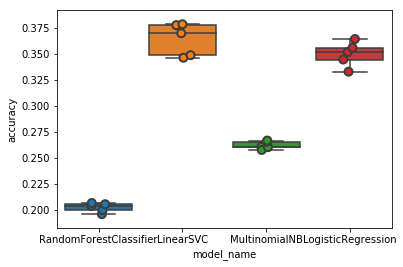

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=42),
]

CV = 5

cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    
    # We are grabbing the index and the scores for each model
    # And then appending to a list a tuple with the name, index, and scores
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

# 
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()


In [14]:
cv_df.groupby('model_name').accuracy.mean()

# https://www.businessinsider.com/everything-you-need-to-know-about-beer-in-one-chart-2015-8
# https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

model_name
LinearSVC                 0.364499
LogisticRegression        0.350161
MultinomialNB             0.262261
RandomForestClassifier    0.202388
Name: accuracy, dtype: float64

In [88]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

In [89]:
user_sim_query = """
SELECT 
review_profilename, 
AVG(review_overall) AS overall, 
beers.name as beer_name, 
breweries.name as brewery_name, 
styles.name as style 
FROM 
reviews, beers, breweries, styles 
WHERE reviews.beer_id = beers.id 
AND beers.style_id = styles.id 
AND beers.brewery_id = breweries.id 
GROUP BY review_profilename, 
style, beer_name, brewery_name 
HAVING AVG(review_overall) > 3.5
AND COUNT(review_profilename) > 10;
"""


user_reviews_grouped = pd.read_sql(user_sim_query, con=engine)

In [90]:
user_reviews_grouped.isnull().sum()

review_profilename    0
overall               0
beer_name             0
brewery_name          0
style                 0
dtype: int64

In [91]:
user_reviews_grouped.head()

,review_profilename,overall,beer_name,brewery_name,style
0,10Crumra,3.75,Milk Chocolate Stout,Rock Bottom Restaurant and Brewery,English Sweet / Milk Stout
1,1971bernat,4.00,Zug Zwang,Granite City Food & Brewery,American Porter
2,1971bernat,4.00,Blue Brunette,Granite City Food & Brewery,English Oatmeal Stout
3,1971bernat,4.00,Broad Axe Stout,Granite City Food & Brewery,English Oatmeal Stout
4,1971bernat,4.50,Elf's Tale,Granite City Food & Brewery,Winter Warmer


In [101]:
user_reviews_grouped.tail()

,review_profilename,overall,beer_name,brewery_name,style
2325,Zetcha7x,3.75,Kolsch,Rock Bottom Restaurant and Brewery,German Kölsch
2326,Zetcha7x,3.75,Red Rocks Red,Rock Bottom Restaurant and Brewery,Irish Red Ale
2327,zimm421,3.75,Gordon Biersch Winter Bock,Gordon Biersch Brewery & Restaurant,German Doppelbock
2328,zook74,4.00,American Dream Ale,Rock Bottom Restaurant and Brewery,American IPA
2329,zsk,5.00,Gordon Biersch Kölsch,Gordon Biersch Brewery & Restaurant,German Kölsch


In [104]:
user_reviews_grouped.groupby(["review_profilename","style","beer_name"])["overall"].mean()

review_profilename  style                        beer_name                         
10Crumra            English Sweet / Milk Stout   Milk Chocolate Stout                  3.75
1971bernat          American Porter              Zug Zwang                             4.00
                    English Oatmeal Stout        Blue Brunette                         4.00
                                                 Broad Axe Stout                       4.00
                    Winter Warmer                Elf's Tale                            4.50
22Blue              Belgian Tripel               Belgian Tripel                        3.75
773-F-I-B           Pumpkin Beer                 The Wicked Brewski                    3.75
AC-Mivsek           Belgian Tripel               Belgian Tripel                        3.75
ADR                 English Oatmeal Stout        Rock Bottom Oatmeal Stout             4.00
                    Russian Imperial Stout       Black Bull Imperial Stout             4

In [105]:
# TODO USER TO USER recommendation

# # We'll use the famous SVD algorithm.
# algo = SVD()

# # Run 5-fold cross-validation and print results
# cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)